# feature_generation

In [43]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
import nbimporter
import pre_processing

### Funciones auxiliares

In [45]:
def corr(df):
    return df.corr()['precio'].sort_values(ascending=False)[1:]

In [46]:
def aniomes(anio, mes):
    if len(str(mes)) == 1:
        return int(str(anio)+'0'+str(mes))
    return int(str(anio)+str(mes))

In [47]:
def aniomesdia(anio, mes, dia):
    anio= str(anio)
    mes= str(mes)
    dia= str(dia)
    
    if len(mes) == 1:
        mes = '0'+mes
    if len(dia) == 1:
        dia = '0'+dia
    
    return int(anio+mes+dia)

In [48]:
def aniomesdia(dt):
    anio= str(dt.year)
    mes= str(dt.month)
    dia= str(dt.day)
    
    if len(mes) == 1:
        mes = '0'+mes
    if len(dia) == 1:
        dia = '0'+dia
        
    return int(anio+mes+dia)
    

In [49]:
def contiene_indicadores(descripcion, indicadores):
    for indicador in indicadores:
        if indicador in str(descripcion).lower():
            return 1
    return 0

In [50]:
def binning_habitaciones(x):
    if (x==-1):
        return 'unknown'
    elif x==1:
        return 'monoambiente'
    elif (x==2):
        return 'dos ambientes'
    elif (x==3):
        return 'tres ambientes'
    elif (x==4):
        return 'cuatro ambientes'
    elif (x==5):
        return 'cinco ambientes'
    else:
        return 'mas de 5 ambientes'

In [51]:
def binning_antiguedad_1(x):
    if (x==-1):
        return 'unknown'
    elif x==0:
        return 'new'
    elif (x<=5):
        return '0 a 5'
    elif (x<=10):
        return '5 a 10'
    elif (x<=15):
        return '10 a 15'
    elif (x<=20):
        return '15 a 20'
    elif (x<=30):
        return '20 a 30'
    elif (x<=50):
        return '30 a 50'
    else:
        return '+50'
    

In [52]:
def binning_antiguedad_2(x):
    if (x==-1):
        return 'unknown'
    elif x==0:
        return 'new'
    elif (x<=10):
        return 'hasta 10'
    else:
        return 'mas de 10'
    

In [53]:
filas_train = 240000
filas_test = 60000

# Desarollo

In [54]:
df = pre_processing.load_appended_dataset()

In [55]:
display(df.head(1))
print(df.shape)

,titulo,descripcion,direccion,tipodepropiedad,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
id,,,,,,,,,,,,,,,,,,,,
254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Avenida Division del Norte 2005,Apartamento,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,2015-08-23,0,0,0,0,0,2273000.0


(300000, 20)


In [56]:
guardar = False

In [57]:
dataframes = []
features = {}
features_types = {}
features_types['bernoulli'] = []
features_types['float'] = []
features_types['uint8'] = []
features_types['uint16'] = []
features_types['uint32'] = []

# Tratamiento de variables importantes con nulos

### Metros cubiertos y totales
`metrostotales` es una categoria muy importante, asi como `metrostotales`. Es la principal feature que determina el precio de una propiedad. Lamentablemente, muchas propiedades no tienen datos en estas filas o tienen datos inconsistentes. En esta seccion analizaremos que hacer con esto.

###### Outliers
Ademas de poseer muchos nulos, el dataset tambien posee datos que, por una razon u otra, no tienen sentido. El objetivo de esta seccion es, ya que no podemos eliminarlos porque perderiamos mas de la mitad de los datos y para entrenar esto no tiene sentido, decidimos generar features que indiquen si la fila presenta o no algun dato sin sentido.

In [58]:
dicc_metros = {}
df_metros = df[['metroscubiertos', 'metrostotales']].copy()
df_metros.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 254099 to 72612
Data columns (total 2 columns):
metroscubiertos    278301 non-null float64
metrostotales      235878 non-null float64
dtypes: float64(2)
memory usage: 6.9 MB


In [59]:
# Generamos columna que nos diga si los metros totales son confiables.

In [60]:
df_metros['metrostotales_confiables'] = df_metros.apply(lambda x: 1 if ((x['metrostotales'] > x['metroscubiertos']) & (x['metroscubiertos'] > 0)) else 0, axis=1)

In [61]:
df_metros['metrostotales_confiables'].sum()

78794

In [62]:
# Vemos que solo en 80.000 datos de 300.000 (!!!) tiene sentido utilizar los metros totales.
# Vamos a tomar una serie de medidas para rellenar los nulos en estos campos, para tener mas informacion.
# Son consideraciones que pueden ser erroneas, pero sera un intento por salvar los datos.

Vemos que solo en 80.000 datos de 300.000 (!!!) tiene sentido utilizar los metros totales.
Vamos a tomar una serie de medidas para rellenar los nulos en estos campos, para tener mas informacion. Son consideraciones que pueden ser erroneas, pero sera un intento por salvar los datos.

- CASO 1: Los `metroscubiertos` son distintos de `nan`, pero los `metrostotales` son `nan`.
- CASO 2: Los `metroscubiertos` son distintos de `nan`, los `metrostotales` son menores que los cubiertos.
- CASO 3: Los `metroscubiertos` son `nan`, pero los `metrostotales` son distintos de `nan`.

In [63]:
df_metros.loc[(df_metros['metroscubiertos'].isnull()) & (df_metros['metrostotales'].isnull())]

,metroscubiertos,metrostotales,metrostotales_confiables
id,,,


In [64]:
# OBSERVACION! Vemos que no hay propiedades que tengan ambas informaciones faltantes. Esto nos permite tomar como
# primer opcion, solucionar los casos llenando la info del faltante con la del presente.

In [65]:
#CASO 3
df_metros['metroscubiertos_alt'] = df_metros['metroscubiertos'].fillna(df_metros['metrostotales'])

In [66]:
# Esta alternativa parece tener mucho sentido, ya que puede pasar que haya gente que directamente ponga el dato
# en metros totales, y no complete los cubiertos.

# En el CASO 1 hay que tener un poco mas de cuidado, ya que los metros totales son por definicion MAYORES O
# IGUALES a los cubiertos. En esta primer alternativa, los consideraremos iguales en el caso de nans.

In [67]:
df_metros['metrostotales_alt'] = df_metros['metrostotales'].fillna(df_metros['metroscubiertos'])

In [68]:
# regeneramos la columna de metros confiables
df_metros['metrostotales_confiables_alt'] = df_metros.apply(lambda x: 1 if ((x['metrostotales_alt'] > x['metroscubiertos_alt']) & (x['metroscubiertos_alt'] > 0)) else 0, axis=1)

In [69]:
# En este caso ya solucionamos entonces caso 1 y 3. Ahora nos falta ver que hacemos con las propiedades que tienen
# metros totales MENORES a los cubiertos...

In [70]:
df_metros.loc[(df_metros['metroscubiertos'] > df_metros['metrostotales'])].shape[0]

88101

In [71]:
# Vemos que tenemos 88 mil datos con este problema. Vamos a analizar que tanta diferencia hay...

Como interpretar esto? Proponemos tres ideas:

**Idea 1**: la carga se realizo al reves, es decir que los metros cubiertos serian los metros totales, y los metros totales los metros cubiertos.

**Idea 2**: los metros totales representan en realidad, metros descubiertos. Por lo que los metros totales los re-calculamos como la suma entre los totales y los cubiertos.

In [72]:
df_metros.head()

,metroscubiertos,metrostotales,metrostotales_confiables,metroscubiertos_alt,metrostotales_alt,metrostotales_confiables_alt
id,,,,,,
254099,80.0,80.0,0,80.0,80.0,0
53461,268.0,180.0,0,268.0,180.0,0
247984,144.0,166.0,1,144.0,166.0,1
209067,63.0,67.0,1,63.0,67.0,1
185997,95.0,95.0,0,95.0,95.0,0


In [73]:
df_metros.loc[(df_metros['metroscubiertos_alt'] > df_metros['metrostotales_alt'])].shape[0]

88101

In [74]:
# idea 1: los metros cubiertos serian los metros totales, y los metros totales los metros cubiertos.

df_metros['metrostotales_i1'] = df_metros.apply(lambda x: (x['metroscubiertos_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metrostotales_alt']), axis=1)
df_metros['metroscubiertos_i1'] = df_metros.apply(lambda x: (x['metrostotales_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metroscubiertos_alt']), axis=1)

In [75]:
# idea 2: los metros totales son metros descubiertos, entonces metrostotales = metroscubiertos + metrostotales
df_metros['metrostotales_i2'] = df_metros.apply(lambda x: (x['metrostotales_alt'] + x['metroscubiertos_alt']) if (x['metroscubiertos_alt'] > x['metrostotales_alt']) else (x['metrostotales_alt']), axis=1)

#### FEATURES NUEVAS DOCUMENTADAS

- `metrostotales_confiables`: dato valido y con sentido, considerando las features originales.
- `metrostotales_confiables_alt`: dato valido y con sentido, considerando las features _alt.

- `metroscubiertos_alt`: llenar los nulos de metros cubiertos con el dato de metros totales.
- `metrostotales_alt`: llenar los nulos de metros totales con el dato de metros cubiertos.
- `metroscubiertos_i1`: si los metros cubiertos eran mayores a los totales, se invierten.
- `metrostotales_i1`: si los metros cubiertos eran mayores a los totales, se invierten.
- `metrostotales_i2`: se considera que si los metros cubiertos son mayores a los totales, entonces en realidad lo que habia en totales eran metros descubiertos. Se calcula la suma.


In [76]:
df_metros.drop(['metroscubiertos', 'metrostotales'], axis=1, inplace=True)

In [77]:
features_types['bernoulli'] += ['metrostotales_confiables', 'metrostotales_confiables_alt']
features_types['uint16'] += ['metroscubiertos_alt', 'metrostotales_alt', 'metrostotales_i1',
                             'metroscubiertos_i1', 'metrostotales_i2']

In [78]:
# proponemos las alternativas en el dic:
['metrostotales_confiables', 'metroscubiertos_alt', 'metrostotales_alt',
 'metrostotales_i1', 'metroscubiertos_i1', 'metrostotales_i2', 'metrostotales_confiables_alt']

dicc_metros[0] = ['metroscubiertos_alt', 'metrostotales_alt']
dicc_metros[1] = ['metroscubiertos_alt', 'metrostotales_alt', 'metrostotales_confiables_alt']
dicc_metros[2] = ['metroscubiertos_i1', 'metrostotales_i1']
dicc_metros[3] = ['metroscubiertos_i1', 'metrostotales_i1', 'metrostotales_confiables_alt']
dicc_metros[4] = ['metroscubiertos_alt', 'metrostotales_i2']
dicc_metros[5] = ['metroscubiertos_alt', 'metrostotales_i2', 'metrostotales_confiables_alt']

# ME LA JUEGO QUE LA MEJOR ES LA [3] -mau

In [79]:
# guardamos todo lo generado
if guardar:
    df_metros.to_csv('features/metros.csv')
features['metros'] = dicc_metros
dataframes.append(df_metros)

# Encoding de variables categoricas

### TIPO DE PROPIEDAD

In [80]:
# En el TP1 vimos que la mayoria de las propiedades eran casas o departamentos. Vamos a chequear esto:
dicc_tipodepropiedad = {}
df_tipodepropiedad = df[['tipodepropiedad']].copy()
df['tipodepropiedad'].value_counts(normalize=True)

Casa                  0.590440
Apartamento           0.238573
Casa en condominio    0.080693
Terreno               0.041300
Local Comercial       0.012820
Otro                  0.011767
Oficina comercial     0.007187
Bodega comercial      0.005887
Edificio              0.005800
Terreno comercial     0.005533
Name: tipodepropiedad, dtype: float64

In [81]:
df['antiguedad'].describe()

count    245731.000000
mean          8.123432
std           9.563650
min           0.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          80.000000
Name: antiguedad, dtype: float64

In [82]:
df['habitaciones'].value_counts()

3.0     152388
2.0      72195
4.0      31328
1.0       6322
5.0       5760
6.0       2103
7.0        675
8.0        497
10.0       411
9.0        222
Name: habitaciones, dtype: int64

In [83]:
# Vemos que un 80% de las propiedades son casas o apartamentos. En vista de esto, propondremos distintos tipos
# de encoding para los tipos de propiedad.

##### Probamos algunas alternativas de encoding...

In [84]:
# label encoder
encoder = LabelEncoder()
encoded = df[['tipodepropiedad']].apply(encoder.fit_transform).add_suffix("_le")

dicc_tipodepropiedad[0] = encoded.columns.to_list()
features_types['uint8'] += dicc_tipodepropiedad[0]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [85]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df['tipodepropiedad']).add_suffix("_ohe")

dicc_tipodepropiedad[1] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_tipodepropiedad[1]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [86]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df['tipodepropiedad']).add_suffix("_binary")

dicc_tipodepropiedad[2] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_tipodepropiedad[2]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [87]:
# polynomial encoder
encoder = ce.polynomial.PolynomialEncoder()
encoded = encoder.fit_transform(df['tipodepropiedad']).add_suffix("_pol")

dicc_tipodepropiedad[3] = encoded.columns.to_list()
features_types['float'] += dicc_tipodepropiedad[3]
df_tipodepropiedad = df_tipodepropiedad.join(encoded, on='id')

In [88]:
# probar otros encoders como target encoding...

In [89]:
# Ahora generamos otras combinaciones que creemos que pueden ser interesantes:

df_tipodepropiedad['es_casa'] = df['tipodepropiedad'].map(lambda x: 1 if x == 'Casa' else 0)
df_tipodepropiedad['es_apart'] = df['tipodepropiedad'].map(lambda x: 1 if x == 'Apartamento' else 0)

features_types['bernoulli'] += ['es_casa', 'es_apart']

#definimos alternativas manualmente
dicc_tipodepropiedad[4] = ['es_casa', 'es_apart']
dicc_tipodepropiedad[5] = ['es_casa', 'es_apart'] + dicc_tipodepropiedad[0]
dicc_tipodepropiedad[6] = ['es_casa', 'es_apart'] + dicc_tipodepropiedad[2]

In [90]:
# guardamos el csv
df_tipodepropiedad.drop('tipodepropiedad', axis=1, inplace=True)
if guardar:
    df_tipodepropiedad.to_csv('features/tipodepropiedad_encoded.csv')
features['tipodepropiedad_encoded'] = dicc_tipodepropiedad
dataframes.append(df_tipodepropiedad)

### PROVINCIA

In [91]:
# En el TP1 vimos que la mayoria de las publicaciones venian de distrito federal, siendo este un atributo
# muy importante a la hora de determinar el precio final.
dicc_provincia = {}
df_provincia = df[['provincia']].copy()
df['provincia'].value_counts()[:10]

Distrito Federal    73535
Edo. de México      51807
Jalisco             26559
Querétaro           21313
Nuevo León          19295
Puebla              12903
San luis Potosí     10527
Yucatán              9950
Morelos              9196
Veracruz             7202
Name: provincia, dtype: int64

In [92]:
# Vamos a generar distintos encodings para representar esta informacion

In [93]:
# label encoder
encoder = LabelEncoder()
encoded = df[['provincia']].apply(encoder.fit_transform).add_suffix("_le")

dicc_provincia[0] = encoded.columns.to_list()
features_types['uint8'] += dicc_provincia[0]
df_provincia = df_provincia.join(encoded, on='id')

In [94]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df['provincia']).add_suffix("_ohe")

dicc_provincia[1] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_provincia[1]
df_provincia = df_provincia.join(encoded, on='id')

In [95]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df['provincia']).add_suffix("_binary")

dicc_provincia[2] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_provincia[2]
df_provincia = df_provincia.join(encoded, on='id')

In [96]:
# Ahora generamos otras combinaciones que creemos que pueden ser interesantes:

# one hot encoding para el top 10 de provincias:
top_prov = []
for provincia in df['provincia'].value_counts().index.to_list()[:10]:
    name = 'es_'+str(provincia)
    top_prov.append(name)
    df_provincia[name] = df_provincia['provincia'].map(lambda x: 1 if x == str(provincia) else 0)

features_types['bernoulli'] += top_prov

#definimos alternativas manualmente
dicc_provincia[3] = top_prov
dicc_provincia[4] = top_prov[:5] + dicc_provincia[0]
dicc_provincia[5] = top_prov[:2] + dicc_provincia[0]
dicc_provincia[6] = top_prov[:2] + dicc_provincia[2]

In [97]:
# guardamos el csv
df_provincia.drop('provincia', axis=1, inplace=True)
df_provincia.to_csv('features/provincia_encoded.csv')
features['provincia_encoded'] = dicc_provincia
dataframes.append(df_provincia)

### CIUDAD

In [98]:
# Esta variable es conflictiva por la cantidad de valores distintos que posee:
dicc_ciudad = {}
df_ciudad = df[['ciudad', 'metroscubiertos', 'precio']].copy()
df['ciudad'].value_counts()

Querétaro              15874
Benito Juárez          13817
Zapopan                12924
San Luis Potosí         9875
Mérida                  9000
                       ...  
Naranjos Amatlán           1
Nazareno Etla              1
Nochistlán de Mejía        1
Nopaltepec                 1
Abalá                      1
Name: ciudad, Length: 922, dtype: int64

In [99]:
# Como vemos, son 922 valores distintos. Vamos a ver entonces, hasta que ciudad debemos sumar para conservar un
# buen porcentaje.

In [100]:
for i in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500, 900]:
    print(f"Con {i} ciudades, conservamos el {int(df['ciudad'].value_counts(normalize=True)[:i].sum()*100)}% de los datos.")

Con 10 ciudades, conservamos el 34% de los datos.
Con 20 ciudades, conservamos el 53% de los datos.
Con 30 ciudades, conservamos el 65% de los datos.
Con 40 ciudades, conservamos el 73% de los datos.
Con 50 ciudades, conservamos el 79% de los datos.
Con 60 ciudades, conservamos el 83% de los datos.
Con 70 ciudades, conservamos el 87% de los datos.
Con 80 ciudades, conservamos el 89% de los datos.
Con 90 ciudades, conservamos el 91% de los datos.
Con 100 ciudades, conservamos el 93% de los datos.
Con 200 ciudades, conservamos el 98% de los datos.
Con 500 ciudades, conservamos el 99% de los datos.
Con 900 ciudades, conservamos el 99% de los datos.


In [101]:
# Para evitar outliers, vamos a agrupar a las ciudades que tengan pocos datos.

In [102]:
ciudades = df_ciudad['ciudad'].value_counts()

In [103]:
whitelist = []
for i in range(ciudades.count()):
    if (ciudades.iloc[i] >= 500):
        nombre = ciudades.index[i]
        whitelist.append(nombre)

In [104]:
df_ciudad['ciudad'] = df_ciudad['ciudad'].map(lambda x: x if x in whitelist else 'Otra') 

In [105]:
# label encoder
encoder = LabelEncoder()
encoded = df_ciudad[['ciudad']].apply(encoder.fit_transform).add_suffix("_le")

dicc_ciudad[0] = encoded.columns.to_list()
features_types['uint16'] += dicc_ciudad[0]
df_ciudad = df_ciudad.join(encoded, on='id')

In [106]:
# binary encoder
encoder = ce.binary.BinaryEncoder()
encoded = encoder.fit_transform(df_ciudad['ciudad']).add_suffix("_binary")

dicc_ciudad[1] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_ciudad[1]
df_ciudad = df_ciudad.join(encoded, on='id')

In [107]:
# Para one hot encoding claramente es mucho mas complicado, porque son muchos valores unicos distintos,
# por lo que haremos lo siguiente: plantearemos varias alternativas.

# La primera sera generar onehot encoding para las primeras 50 ciudades, que como vimos, nos permite conservar
# un 80% de precision, y a las demas las empaquetamos en una ciudad "Otra"

In [108]:
whitelist = df_ciudad['ciudad'].value_counts().index.to_list()[:50]
df_ciudad['ciudad_top50'] = df_ciudad['ciudad'].map(lambda x: x if x in whitelist else 'Otra')

In [109]:
# one hot encoder
encoder = ce.one_hot.OneHotEncoder()
encoded = encoder.fit_transform(df_ciudad['ciudad_top50']).add_suffix("_ohe")

dicc_ciudad[2] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_ciudad[2]
df_ciudad = df_ciudad.join(encoded, on='id').drop('ciudad_top50', axis=1)

In [110]:
# Otra alternativa sera distinguir ciudades caras de baratas mediante distintos metodos:

# 1. Calcularemos cual es el precio promedio del metro cuadrado, realizaremos un binning para distinguir
# entre ciudades baratas, normales, y caras, y haremos one hot encoding para este binning.

In [111]:
precio_ciudades = df_ciudad.head(filas_train).groupby('ciudad')['metroscubiertos', 'precio'].agg('sum')

In [112]:
precio_ciudades['precio_prom_mt_ciudad'] = precio_ciudades.apply(lambda x: (int(x['precio']/x['metroscubiertos'])), axis=1)

In [113]:
precio_ciudades = precio_ciudades[['precio_prom_mt_ciudad']]

In [114]:
df_ciudad['precio_prom_mt_ciudad'] = df_ciudad['ciudad'].map(lambda x: precio_ciudades.loc[x][0])

In [115]:
df_ciudad.drop(['metroscubiertos', 'precio'], axis=1, inplace=True)

In [116]:
categorias = df_ciudad['precio_prom_mt_ciudad'].describe()

In [117]:
mean = categorias[1]
std = categorias[2]

In [118]:
df_ciudad['ciudad_cara'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if (x>(mean+std)) else 0)
df_ciudad['ciudad_normal'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if ((x>(mean-std)) & (x<(mean+std))) else 0)
df_ciudad['ciudad_barata'] = df_ciudad['precio_prom_mt_ciudad'].map(lambda x: 1 if (x<(mean-std)) else 0)

In [119]:
df_ciudad.drop(['ciudad', 'precio_prom_mt_ciudad'], axis=1, inplace=True)

In [120]:
# finalmente, generamos lo que queriamos.
df_ciudad.head()

,ciudad_le,ciudad_0_binary,ciudad_1_binary,ciudad_2_binary,ciudad_3_binary,ciudad_4_binary,ciudad_5_binary,ciudad_6_binary,ciudad_7_binary,ciudad_top50_1_ohe,...,ciudad_top50_44_ohe,ciudad_top50_45_ohe,ciudad_top50_46_ohe,ciudad_top50_47_ohe,ciudad_top50_48_ohe,ciudad_top50_49_ohe,ciudad_top50_50_ohe,ciudad_cara,ciudad_normal,ciudad_barata
id,,,,,,,,,,,,,,,,,,,,,
254099,8,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0
53461,40,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
247984,84,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
209067,55,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
185997,93,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [121]:
dicc_ciudad[3] = ['ciudad_cara', 'ciudad_barata', 'ciudad_normal']
features_types['bernoulli'] += dicc_ciudad[3]

In [122]:
# agregamos alternativas a mano
dicc_ciudad[4] = dicc_ciudad[3] + dicc_ciudad[0]
dicc_ciudad[5] = dicc_ciudad[3] + dicc_ciudad[1]
dicc_ciudad[6] = dicc_ciudad[3] + dicc_ciudad[2]

In [123]:
# guardamos el csv
if guardar:
    df_ciudad.to_csv('features/ciudad_encoded.csv')
features['ciudad_encoded'] = dicc_ciudad
dataframes.append(df_ciudad)

# Generacion de nuevas features

### FECHA

In [124]:
# Es de gran importancia manejar la fecha para el modelo, ya que en gran parte la fecha tiene informacion
# importante sobre la evolucion de los precios.

dicc_fecha = {}
df_fecha = df[['fecha', 'metroscubiertos', 'precio']].copy()

In [125]:
df_fecha['anio'] = df_fecha['fecha'].dt.year
df_fecha['mes'] = df_fecha['fecha'].dt.month
df_fecha['dia'] = df_fecha['fecha'].dt.day
df_fecha['timestamp'] = df_fecha['fecha'].apply(lambda x: datetime.timestamp(x))
df_fecha['aniomes'] = df_fecha.apply(lambda row: aniomes(row['anio'], row['mes']), axis=1)

In [126]:
# calculamos el precio promedio del metro cubierto por aniomes (OJO, COLUMNA PELIGROSA ==> OVERFITTING)
precio_mtcubierto_aniomes = df_fecha.head(filas_train).groupby(['aniomes'])['metroscubiertos', 'precio'].agg(sum).apply(lambda x: x['precio']/x['metroscubiertos'], axis=1)
df_fecha['precio_promedio_metrocubierto_aniomes'] = df_fecha['aniomes'].apply(lambda x: precio_mtcubierto_aniomes[x])

In [127]:
# calculamos el precio promedio del metro cubierto por mes (OJO, COLUMNA PELIGROSA ==> OVERFITTING)
precio_mtcubierto_mes = df_fecha.head(filas_train).groupby(['mes'])['metroscubiertos', 'precio'].agg(sum).apply(lambda x: x['precio']/x['metroscubiertos'], axis=1)
df_fecha['precio_promedio_metrocubierto_mes'] = df_fecha['mes'].apply(lambda x: precio_mtcubierto_mes[x])

In [128]:
df_fecha = df_fecha.drop(['fecha', 'precio', 'metroscubiertos'], axis=1)
pasar_a_enteros = ['precio_promedio_metrocubierto_mes', 'precio_promedio_metrocubierto_aniomes']
df_fecha[pasar_a_enteros] = df_fecha[pasar_a_enteros].astype('uint16')

In [129]:
df_fecha.head()

,anio,mes,dia,timestamp,aniomes,precio_promedio_metrocubierto_aniomes,precio_promedio_metrocubierto_mes
id,,,,,,,
254099,2015,8,23,1.440299e+09,201508,16183,15363
53461,2013,6,28,1.372388e+09,201306,14297,15521
247984,2015,10,17,1.445051e+09,201510,15996,15547
209067,2012,3,9,1.331262e+09,201203,13039,15423
185997,2016,6,7,1.465268e+09,201606,16142,15521


In [130]:
# Ahora, antes de guardar los resultados, vamos a analizar si es conveniente realizar alguna transformacion a
# estos datos.

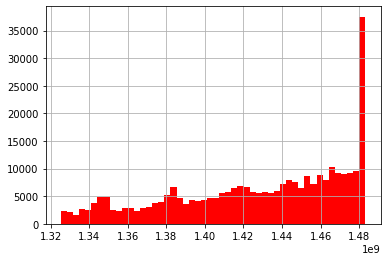

In [131]:
df_fecha['timestamp'].hist(bins=50, color='r'); 

In [132]:
# Vamos a escalar la columna timestamp entre 0 y 1, y lo mismo con la columna aniomes.

In [133]:
tmin = df_fecha['timestamp'].min()
df_fecha['timestamp_scaled'] = df_fecha['timestamp'].map(lambda x: x-tmin)
tmax = df_fecha['timestamp_scaled'].max()
df_fecha['timestamp_scaled'] = df_fecha['timestamp_scaled'].map(lambda x: x/tmax)

In [134]:
tmin = df_fecha['aniomes'].min()
df_fecha['aniomes_scaled'] = df_fecha['aniomes'].map(lambda x: x-tmin)
tmax = df_fecha['aniomes_scaled'].max()
df_fecha['aniomes_scaled'] = df_fecha['aniomes_scaled'].map(lambda x: x/tmax)

In [135]:
df_fecha.head()

,anio,mes,dia,timestamp,aniomes,precio_promedio_metrocubierto_aniomes,precio_promedio_metrocubierto_mes,timestamp_scaled,aniomes_scaled
id,,,,,,,,,
254099,2015,8,23,1.440299e+09,201508,16183,15363,0.728368,0.746959
53461,2013,6,28,1.372388e+09,201306,14297,15521,0.297919,0.255474
247984,2015,10,17,1.445051e+09,201510,15996,15547,0.758488,0.751825
209067,2012,3,9,1.331262e+09,201203,13039,15423,0.037240,0.004866
185997,2016,6,7,1.465268e+09,201606,16142,15521,0.886637,0.985401


In [136]:
dicc_fecha[0] = df_fecha.columns.to_list()
dicc_fecha[1] = ['anio', 'mes', 'dia']
dicc_fecha[2] = ['anio', 'mes', 'aniomes', 'aniomes_scaled']
dicc_fecha[3] = ['anio', 'mes', 'timestamp', 'timestamp_scaled']
dicc_fecha[4] = ['timestamp_scaled', 'aniomes_scaled']
dicc_fecha[5] = ['anio', 'mes', 'timestamp_scaled', 'aniomes_scaled']
dicc_fecha[6] = ['anio', 'mes', 'precio_promedio_metrocubierto_aniomes', 'precio_promedio_metrocubierto_mes',
                 'timestamp_scaled', 'aniomes_scaled']

features_types['uint8'] += ['mes', 'dia']
features_types['uint16'] += ['anio', 'precio_promedio_metrocubierto_aniomes',
                            'precio_promedio_metrocubierto_mes']
features_types['uint32'] += ['aniomes']
features_types['float'] += ['timestamp', 'timestamp_scaled', 'aniomes_scaled']

In [137]:
# Generaremos ahora OHE para aniomes.
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_fecha['aniomes'].astype('category')).add_suffix("_ohe")

dicc_fecha[7] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_fecha[7]
df_fecha = df_fecha.join(encoded, on='id')

In [138]:
# guardamos el csv
if guardar:
    df_fecha.to_csv('features/fecha.csv')
features['fecha'] = dicc_fecha
dataframes.append(df_fecha)

### DESCRIPCION

In [139]:
# La idea es analizar la descripcion en busqueda de data interesante que no este incorporada en el
# dataset original. Para esto, procesaremos el texto en busqueda de indicadores.

dicc_descripcion = {}
df_descripcion = df[['descripcion', 'titulo']].copy()

In [140]:
indicadores = ["jardin", "patio", "jardín"]
df_descripcion["jardin_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["jardin_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["jardin"] = df_descripcion.apply(lambda x: ((x['jardin_des']) | (x['jardin_tit'])), axis=1)

indicadores = ["vigilancia", "seguridad"]
df_descripcion["vigilancia_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["vigilancia_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["vigilancia"] = df_descripcion.apply(lambda x: ((x['vigilancia_des']) | (x['vigilancia_tit'])), axis=1)

indicadores = ["aire acondicionado", "aires acondicionados"]
df_descripcion["aire_acondicionado_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["aire_acondicionado_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["aire_acondicionado"] = df_descripcion.apply(lambda x: ((x['aire_acondicionado_des']) | (x['aire_acondicionado_tit'])), axis=1)

indicadores = ["ventilador", "ventiladores"]
df_descripcion["ventilador_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["ventilador_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["ventilador"] = df_descripcion.apply(lambda x: ((x['ventilador_des']) | (x['ventilador_tit'])), axis=1)

indicadores = ["calefaccion", "caloventor", "estufa", "calefacción", "calentador"]
df_descripcion["calefaccion_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["calefaccion_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["calefaccion"] = df_descripcion.apply(lambda x: ((x['calefaccion_des']) | (x['calefaccion_tit'])), axis=1)

indicadores = ["parrilla", "asador", "asado", "parrillada"]
df_descripcion["parrilla_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["parrilla_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["parrilla"] = df_descripcion.apply(lambda x: ((x['parrilla_des']) | (x['parrilla_tit'])), axis=1)

indicadores = ["terraza"]
df_descripcion["terraza_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["terraza_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["terraza"] = df_descripcion.apply(lambda x: ((x['terraza_des']) | (x['terraza_tit'])), axis=1)

indicadores = ["jacuzzi", "sauna"]
df_descripcion["lujo_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["lujo_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["lujo"] = df_descripcion.apply(lambda x: ((x['lujo_des']) | (x['lujo_tit'])), axis=1)

indicadores = ["cuarto de servicio", "salon de servicio", "salón de servicio", "salon servicio",
              "salón servicio", "cuarto servicio", "sala servicio", "sala de servicio"]
df_descripcion["servicio_des"] = df_descripcion["descripcion"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["servicio_tit"] = df_descripcion["titulo"].map(lambda x: contiene_indicadores(x, indicadores))
df_descripcion["servicio"] = df_descripcion.apply(lambda x: ((x['servicio_des']) | (x['servicio_tit'])), axis=1)


drop_list = ['jardin_des', 'jardin_tit', 'vigilancia_des', 'vigilancia_tit', 'aire_acondicionado_des',
            'aire_acondicionado_tit', 'ventilador_des', 'ventilador_tit', 'calefaccion_des', 'calefaccion_tit',
            'parrilla_des', 'parrilla_tit', 'terraza_des', 'terraza_tit', 'lujo_des', 'lujo_tit',
            'servicio_des', 'servicio_tit']
df_descripcion.drop(drop_list, axis=1, inplace=True)

In [141]:
df_descripcion[['jardin', 'vigilancia', 'aire_acondicionado', 'ventilador', 'calefaccion', 'parrilla', 'terraza', 'lujo', 'servicio']].sum()

jardin                128653
vigilancia             66033
aire_acondicionado      8302
ventilador              3503
calefaccion            17439
parrilla               17634
terraza                54148
lujo                   12926
servicio               50057
dtype: int64

In [142]:
df_descripcion.drop(['titulo', 'descripcion'], axis=1, inplace=True)

In [143]:
columnas = df_descripcion.columns.to_list()

In [144]:
dicc_descripcion[0] = columnas
features_types['bernoulli'] += columnas

In [145]:
# guardamos el csv
if guardar:
    df_descripcion.to_csv('features/descripcion.csv')
features['descripcion'] = dicc_descripcion
dataframes.append(df_descripcion)

### METRICAS DE LOS FEATURES

In [146]:
dicc_metricas = {}
df_metricas = df[['metroscubiertos','ciudad']].copy().reset_index()

##### MEAN Y STD DE SUPERFICIE CUBIERTA POR CIUDAD

In [147]:
avg_metroscubiertos = df_metricas.groupby('ciudad').agg({"metroscubiertos":["mean","std"]}).reset_index()
avg_metroscubiertos.columns = ['ciudad','metroscubiertos_mean','metroscubiertos_std']
df_metricas = pd.merge(df_metricas,avg_metroscubiertos,how='inner',on='ciudad').set_index('id')
df_metricas.drop(['metroscubiertos', 'ciudad'], axis=1, inplace=True)

In [148]:
dicc_metricas[0] = df_metricas.columns.to_list()
features_types['float'] += df_metricas.columns.to_list()

In [149]:
# guardamos el csv
if guardar:
    df_metricas.to_csv('features/metricas.csv')
dataframes.append(df_metricas)

MEAN Y STD DE SUPERFICIE CUBIERTA POR TIPO DE PROPIEDAD

In [150]:
df_metricas2 = df[['metroscubiertos','tipodepropiedad']].copy().reset_index()

In [151]:
avg_metroscubiertos_tipo = df_metricas2.groupby('tipodepropiedad').agg({"metroscubiertos":["mean","std"]}).reset_index()
avg_metroscubiertos_tipo.columns = ['tipodepropiedad','metroscubiertos_city_mean','metroscubiertos_city_std']
df_metricas2 = pd.merge(df_metricas2,avg_metroscubiertos_tipo,how='inner',on='tipodepropiedad').set_index('id')
df_metricas2.drop(['metroscubiertos', 'tipodepropiedad'], axis=1, inplace=True)

In [152]:
dicc_metricas[1] = df_metricas2.columns.to_list()
features_types['float'] += df_metricas2.columns.to_list()

In [153]:
features['metricas'] = dicc_metricas
dataframes.append(df_metricas2)

### BINNING (+OHE)

In [154]:
# binning para antiguedad
dicc_antiguedad = {}
df_antiguedad = df[['antiguedad']].copy()

In [155]:
# binning general (9 bins)
df_antiguedad['antiguedad'].fillna(-1, inplace=True)
df_antiguedad['antiguedad'] = df_antiguedad['antiguedad'].astype(int)
df_antiguedad['antiguedad_binning'] = df_antiguedad['antiguedad'].map(lambda x: binning_antiguedad_1(x))

In [156]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_antiguedad['antiguedad_binning']).add_suffix("_ohe1")

dicc_antiguedad[0] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_antiguedad[0]
df_antiguedad = df_antiguedad.join(encoded, on='id')

In [157]:
# binning especifico (4 bins)
df_antiguedad['antiguedad_binning_2'] = df_antiguedad['antiguedad'].map(lambda x: binning_antiguedad_2(x))

In [158]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_antiguedad['antiguedad_binning_2']).add_suffix("_ohe2")

dicc_antiguedad[1] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_antiguedad[1]
df_antiguedad = df_antiguedad.join(encoded, on='id')
df_antiguedad.drop(['antiguedad', 'antiguedad_binning', 'antiguedad_binning_2'], axis=1, inplace=True)

In [159]:
# guardamos el csv
if guardar:
    df_antiguedad.to_csv('features/antiguedad.csv')
features['antiguedad'] = dicc_antiguedad
dataframes.append(df_antiguedad)

In [160]:
# binning para habitaciones
dicc_habitaciones = {}
df_habitaciones = df[['habitaciones']].copy()

In [161]:
df_habitaciones['habitaciones'].fillna(-1, inplace=True)
df_habitaciones['habitaciones'] = df_habitaciones['habitaciones'].astype(int)
df_habitaciones['hab_binning'] = df_habitaciones['habitaciones'].map(lambda x: binning_habitaciones(x))

In [162]:
# ohe
encoder = ce.OneHotEncoder()
encoded = encoder.fit_transform(df_habitaciones['hab_binning']).add_suffix("_ohe")

dicc_habitaciones[0] = encoded.columns.to_list()
features_types['bernoulli'] += dicc_habitaciones[0]
df_habitaciones = encoded

In [163]:
# guardamos el csv
if guardar:
    df_habitaciones.to_csv('features/habitaciones.csv')
features['habitaciones'] = dicc_habitaciones
dataframes.append(df_habitaciones)

### COTIZACION DEL USD

In [164]:
# Quizas resulte de interes conocer la cotizacion del dolar en pesos mexicanos, ya que el dolar se toma 
# como moneda de referencia en el mercado inmobiliario en gran parte de America.

# Para eso, se utilizo un dataset de https://es.investing.com/currencies/usd-mxn-historical-data

dicc_extras = {}
df_extras = df_fecha[['aniomes']].copy().reset_index()

In [165]:
# Cargamos el dataset preprocesado en pre_processing.
usd = pd.read_csv('data/usd_mxn_featured.csv', index_col=['aniomes'])

In [166]:
usd['usd_var_mesanterior'] = usd['usd_varianza'].shift(1).fillna(0)
usd['usd_daily_mean_mesanterior'] = usd['daily_mean'].shift(1).fillna(0)

In [167]:
df_extras = pd.merge(df_extras, usd, on='aniomes', how='left').drop('aniomes', axis=1).set_index('id')

In [168]:
df_extras['usd_subio'] = df_extras.apply(lambda x: 1 if (x['usd_daily_mean_mesanterior']<x['daily_mean']) else 0, axis=1)

In [169]:
df_extras.drop('usd_daily_mean_mesanterior', inplace=True, axis=1)

In [170]:
df_extras.head()

,usd_varianza,daily_mean,usd_var_mesanterior,usd_subio
id,,,,
254099,3.96,16.551050,2.37,1
53461,1.16,12.955530,5.46,1
247984,-2.48,16.586802,1.08,0
209067,-0.27,12.734559,-1.50,0
185997,-0.82,18.640750,7.34,1


In [171]:
df_extras.columns = ['usd_variacion', 'usd_precio_promedio_mensual', 'usd_variacion_mes_anterior', 'usd_subio']

In [172]:
dicc_extras[0] = df_extras.columns.to_list()
dicc_extras[1] = ['usd_subio']
dicc_extras[2] = ['usd_precio_promedio_mensual', 'usd_subio']

features_types['float'] += ['usd_variacion', 'usd_precio_promedio_mensual', 'usd_variacion_mes_anterior']
features_types['bernoulli'] += ['usd_subio']

In [173]:
# guardamos el csv
if guardar:
    df_extras.to_csv('features/extras.csv')
features['extras'] = dicc_extras
dataframes.append(df_extras)

# Full DF

In [174]:
# Armamos un df con todas las features.

In [175]:
df.columns

Index(['titulo', 'descripcion', 'direccion', 'tipodepropiedad', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'fecha', 'gimnasio',
       'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [176]:
df = df[['antiguedad', 'habitaciones', 'garages', 'banos', 'metroscubiertos', 'metrostotales', 'gimnasio',
         'usosmultiples', 'piscina', 'escuelascercanas', 'centroscomercialescercanos', 'precio']]

In [177]:
for add in dataframes:
    df = pd.merge(df,add,how='left',left_index=True, right_index=True)  

In [178]:
# guardamos en un csv el dataset final
df.to_csv('data/full_featured.csv')

# Resultados
Como este es un proceso costo en tiempo, devolvemos el diccionario hardcodeado y cargaremos los datos directamente del csv full, pre-procesandolo para optimizar el manejo de la memoria utilizada.

In [181]:
def get_features():
    return {'metros': {0: ['metroscubiertos_alt', 'metrostotales_alt'],
  1: ['metroscubiertos_alt',
   'metrostotales_alt',
   'metrostotales_confiables_alt'],
  2: ['metroscubiertos_i1', 'metrostotales_i1'],
  3: ['metroscubiertos_i1',
   'metrostotales_i1',
   'metrostotales_confiables_alt'],
  4: ['metroscubiertos_alt', 'metrostotales_i2'],
  5: ['metroscubiertos_alt',
   'metrostotales_i2',
   'metrostotales_confiables_alt']},
 'tipodepropiedad_encoded': {0: ['tipodepropiedad_le'],
  1: ['tipodepropiedad_1_ohe',
   'tipodepropiedad_2_ohe',
   'tipodepropiedad_3_ohe',
   'tipodepropiedad_4_ohe',
   'tipodepropiedad_5_ohe',
   'tipodepropiedad_6_ohe',
   'tipodepropiedad_7_ohe',
   'tipodepropiedad_8_ohe',
   'tipodepropiedad_9_ohe',
   'tipodepropiedad_10_ohe'],
  2: ['tipodepropiedad_0_binary',
   'tipodepropiedad_1_binary',
   'tipodepropiedad_2_binary',
   'tipodepropiedad_3_binary',
   'tipodepropiedad_4_binary'],
  3: ['intercept_pol',
   'tipodepropiedad_0_pol',
   'tipodepropiedad_1_pol',
   'tipodepropiedad_2_pol',
   'tipodepropiedad_3_pol',
   'tipodepropiedad_4_pol',
   'tipodepropiedad_5_pol',
   'tipodepropiedad_6_pol',
   'tipodepropiedad_7_pol',
   'tipodepropiedad_8_pol'],
  4: ['es_casa', 'es_apart'],
  5: ['es_casa', 'es_apart', 'tipodepropiedad_le'],
  6: ['es_casa',
   'es_apart',
   'tipodepropiedad_0_binary',
   'tipodepropiedad_1_binary',
   'tipodepropiedad_2_binary',
   'tipodepropiedad_3_binary',
   'tipodepropiedad_4_binary']},
 'provincia_encoded': {0: ['provincia_le'],
  1: ['provincia_1_ohe',
   'provincia_2_ohe',
   'provincia_3_ohe',
   'provincia_4_ohe',
   'provincia_5_ohe',
   'provincia_6_ohe',
   'provincia_7_ohe',
   'provincia_8_ohe',
   'provincia_9_ohe',
   'provincia_10_ohe',
   'provincia_11_ohe',
   'provincia_12_ohe',
   'provincia_13_ohe',
   'provincia_14_ohe',
   'provincia_15_ohe',
   'provincia_16_ohe',
   'provincia_17_ohe',
   'provincia_18_ohe',
   'provincia_19_ohe',
   'provincia_20_ohe',
   'provincia_21_ohe',
   'provincia_22_ohe',
   'provincia_23_ohe',
   'provincia_24_ohe',
   'provincia_25_ohe',
   'provincia_26_ohe',
   'provincia_27_ohe',
   'provincia_28_ohe',
   'provincia_29_ohe',
   'provincia_30_ohe',
   'provincia_31_ohe',
   'provincia_32_ohe',
   'provincia_33_ohe'],
  2: ['provincia_0_binary',
   'provincia_1_binary',
   'provincia_2_binary',
   'provincia_3_binary',
   'provincia_4_binary',
   'provincia_5_binary',
   'provincia_6_binary'],
  3: ['es_Distrito Federal',
   'es_Edo. de México',
   'es_Jalisco',
   'es_Querétaro',
   'es_Nuevo León',
   'es_Puebla',
   'es_San luis Potosí',
   'es_Yucatán',
   'es_Morelos',
   'es_Veracruz'],
  4: ['es_Distrito Federal',
   'es_Edo. de México',
   'es_Jalisco',
   'es_Querétaro',
   'es_Nuevo León',
   'provincia_le'],
  5: ['es_Distrito Federal', 'es_Edo. de México', 'provincia_le'],
  6: ['es_Distrito Federal',
   'es_Edo. de México',
   'provincia_0_binary',
   'provincia_1_binary',
   'provincia_2_binary',
   'provincia_3_binary',
   'provincia_4_binary',
   'provincia_5_binary',
   'provincia_6_binary']},
 'ciudad_encoded': {0: ['ciudad_le'],
  1: ['ciudad_0_binary',
   'ciudad_1_binary',
   'ciudad_2_binary',
   'ciudad_3_binary',
   'ciudad_4_binary',
   'ciudad_5_binary',
   'ciudad_6_binary',
   'ciudad_7_binary'],
  2: ['ciudad_top50_1_ohe',
   'ciudad_top50_2_ohe',
   'ciudad_top50_3_ohe',
   'ciudad_top50_4_ohe',
   'ciudad_top50_5_ohe',
   'ciudad_top50_6_ohe',
   'ciudad_top50_7_ohe',
   'ciudad_top50_8_ohe',
   'ciudad_top50_9_ohe',
   'ciudad_top50_10_ohe',
   'ciudad_top50_11_ohe',
   'ciudad_top50_12_ohe',
   'ciudad_top50_13_ohe',
   'ciudad_top50_14_ohe',
   'ciudad_top50_15_ohe',
   'ciudad_top50_16_ohe',
   'ciudad_top50_17_ohe',
   'ciudad_top50_18_ohe',
   'ciudad_top50_19_ohe',
   'ciudad_top50_20_ohe',
   'ciudad_top50_21_ohe',
   'ciudad_top50_22_ohe',
   'ciudad_top50_23_ohe',
   'ciudad_top50_24_ohe',
   'ciudad_top50_25_ohe',
   'ciudad_top50_26_ohe',
   'ciudad_top50_27_ohe',
   'ciudad_top50_28_ohe',
   'ciudad_top50_29_ohe',
   'ciudad_top50_30_ohe',
   'ciudad_top50_31_ohe',
   'ciudad_top50_32_ohe',
   'ciudad_top50_33_ohe',
   'ciudad_top50_34_ohe',
   'ciudad_top50_35_ohe',
   'ciudad_top50_36_ohe',
   'ciudad_top50_37_ohe',
   'ciudad_top50_38_ohe',
   'ciudad_top50_39_ohe',
   'ciudad_top50_40_ohe',
   'ciudad_top50_41_ohe',
   'ciudad_top50_42_ohe',
   'ciudad_top50_43_ohe',
   'ciudad_top50_44_ohe',
   'ciudad_top50_45_ohe',
   'ciudad_top50_46_ohe',
   'ciudad_top50_47_ohe',
   'ciudad_top50_48_ohe',
   'ciudad_top50_49_ohe',
   'ciudad_top50_50_ohe'],
  3: ['ciudad_cara', 'ciudad_barata', 'ciudad_normal'],
  4: ['ciudad_cara', 'ciudad_barata', 'ciudad_normal', 'ciudad_le'],
  5: ['ciudad_cara',
   'ciudad_barata',
   'ciudad_normal',
   'ciudad_0_binary',
   'ciudad_1_binary',
   'ciudad_2_binary',
   'ciudad_3_binary',
   'ciudad_4_binary',
   'ciudad_5_binary',
   'ciudad_6_binary',
   'ciudad_7_binary'],
  6: ['ciudad_cara',
   'ciudad_barata',
   'ciudad_normal',
   'ciudad_top50_1_ohe',
   'ciudad_top50_2_ohe',
   'ciudad_top50_3_ohe',
   'ciudad_top50_4_ohe',
   'ciudad_top50_5_ohe',
   'ciudad_top50_6_ohe',
   'ciudad_top50_7_ohe',
   'ciudad_top50_8_ohe',
   'ciudad_top50_9_ohe',
   'ciudad_top50_10_ohe',
   'ciudad_top50_11_ohe',
   'ciudad_top50_12_ohe',
   'ciudad_top50_13_ohe',
   'ciudad_top50_14_ohe',
   'ciudad_top50_15_ohe',
   'ciudad_top50_16_ohe',
   'ciudad_top50_17_ohe',
   'ciudad_top50_18_ohe',
   'ciudad_top50_19_ohe',
   'ciudad_top50_20_ohe',
   'ciudad_top50_21_ohe',
   'ciudad_top50_22_ohe',
   'ciudad_top50_23_ohe',
   'ciudad_top50_24_ohe',
   'ciudad_top50_25_ohe',
   'ciudad_top50_26_ohe',
   'ciudad_top50_27_ohe',
   'ciudad_top50_28_ohe',
   'ciudad_top50_29_ohe',
   'ciudad_top50_30_ohe',
   'ciudad_top50_31_ohe',
   'ciudad_top50_32_ohe',
   'ciudad_top50_33_ohe',
   'ciudad_top50_34_ohe',
   'ciudad_top50_35_ohe',
   'ciudad_top50_36_ohe',
   'ciudad_top50_37_ohe',
   'ciudad_top50_38_ohe',
   'ciudad_top50_39_ohe',
   'ciudad_top50_40_ohe',
   'ciudad_top50_41_ohe',
   'ciudad_top50_42_ohe',
   'ciudad_top50_43_ohe',
   'ciudad_top50_44_ohe',
   'ciudad_top50_45_ohe',
   'ciudad_top50_46_ohe',
   'ciudad_top50_47_ohe',
   'ciudad_top50_48_ohe',
   'ciudad_top50_49_ohe',
   'ciudad_top50_50_ohe']},
 'fecha': {0: ['anio',
   'mes',
   'dia',
   'timestamp',
   'aniomes',
   'precio_promedio_metrocubierto_aniomes',
   'precio_promedio_metrocubierto_mes',
   'timestamp_scaled',
   'aniomes_scaled'],
  1: ['anio', 'mes', 'dia'],
  2: ['anio', 'mes', 'aniomes', 'aniomes_scaled'],
  3: ['anio', 'mes', 'timestamp', 'timestamp_scaled'],
  4: ['timestamp_scaled', 'aniomes_scaled'],
  5: ['anio', 'mes', 'timestamp_scaled', 'aniomes_scaled'],
  6: ['anio',
   'mes',
   'precio_promedio_metrocubierto_aniomes',
   'precio_promedio_metrocubierto_mes',
   'timestamp_scaled',
   'aniomes_scaled'],
  7: ['aniomes_1_ohe',
   'aniomes_2_ohe',
   'aniomes_3_ohe',
   'aniomes_4_ohe',
   'aniomes_5_ohe',
   'aniomes_6_ohe',
   'aniomes_7_ohe',
   'aniomes_8_ohe',
   'aniomes_9_ohe',
   'aniomes_10_ohe',
   'aniomes_11_ohe',
   'aniomes_12_ohe',
   'aniomes_13_ohe',
   'aniomes_14_ohe',
   'aniomes_15_ohe',
   'aniomes_16_ohe',
   'aniomes_17_ohe',
   'aniomes_18_ohe',
   'aniomes_19_ohe',
   'aniomes_20_ohe',
   'aniomes_21_ohe',
   'aniomes_22_ohe',
   'aniomes_23_ohe',
   'aniomes_24_ohe',
   'aniomes_25_ohe',
   'aniomes_26_ohe',
   'aniomes_27_ohe',
   'aniomes_28_ohe',
   'aniomes_29_ohe',
   'aniomes_30_ohe',
   'aniomes_31_ohe',
   'aniomes_32_ohe',
   'aniomes_33_ohe',
   'aniomes_34_ohe',
   'aniomes_35_ohe',
   'aniomes_36_ohe',
   'aniomes_37_ohe',
   'aniomes_38_ohe',
   'aniomes_39_ohe',
   'aniomes_40_ohe',
   'aniomes_41_ohe',
   'aniomes_42_ohe',
   'aniomes_43_ohe',
   'aniomes_44_ohe',
   'aniomes_45_ohe',
   'aniomes_46_ohe',
   'aniomes_47_ohe',
   'aniomes_48_ohe',
   'aniomes_49_ohe',
   'aniomes_50_ohe',
   'aniomes_51_ohe',
   'aniomes_52_ohe',
   'aniomes_53_ohe',
   'aniomes_54_ohe',
   'aniomes_55_ohe',
   'aniomes_56_ohe',
   'aniomes_57_ohe',
   'aniomes_58_ohe',
   'aniomes_59_ohe',
   'aniomes_60_ohe']},
 'descripcion': {0: ['jardin',
   'vigilancia',
   'aire_acondicionado',
   'ventilador',
   'calefaccion',
   'parrilla',
   'terraza',
   'lujo',
   'servicio']},
 'metricas': {0: ['metroscubiertos_mean', 'metroscubiertos_std'],
              1: ['metroscubiertos_city_mean','metroscubiertos_city_std']},
 'antiguedad': {0: ['antiguedad_binning_1_ohe1',
   'antiguedad_binning_2_ohe1',
   'antiguedad_binning_3_ohe1',
   'antiguedad_binning_4_ohe1',
   'antiguedad_binning_5_ohe1',
   'antiguedad_binning_6_ohe1',
   'antiguedad_binning_7_ohe1',
   'antiguedad_binning_8_ohe1',
   'antiguedad_binning_9_ohe1'],
  1: ['antiguedad_binning_2_1_ohe2',
   'antiguedad_binning_2_2_ohe2',
   'antiguedad_binning_2_3_ohe2',
   'antiguedad_binning_2_4_ohe2']},
 'habitaciones': {0: ['hab_binning_1_ohe',
   'hab_binning_2_ohe',
   'hab_binning_3_ohe',
   'hab_binning_4_ohe',
   'hab_binning_5_ohe',
   'hab_binning_6_ohe',
   'hab_binning_7_ohe']},
 'extras': {0: ['usd_variacion',
   'usd_precio_promedio_mensual',
   'usd_variacion_mes_anterior',
   'usd_subio'],
  1: ['usd_subio'],
  2: ['usd_precio_promedio_mensual', 'usd_subio']}}

In [180]:
def get_features_types():
    return {'bernoulli': ['tipodepropiedad_1_ohe',
  'tipodepropiedad_2_ohe',
  'tipodepropiedad_3_ohe',
  'tipodepropiedad_4_ohe',
  'tipodepropiedad_5_ohe',
  'tipodepropiedad_6_ohe',
  'tipodepropiedad_7_ohe',
  'tipodepropiedad_8_ohe',
  'tipodepropiedad_9_ohe',
  'tipodepropiedad_10_ohe',
  'tipodepropiedad_0_binary',
  'tipodepropiedad_1_binary',
  'tipodepropiedad_2_binary',
  'tipodepropiedad_3_binary',
  'tipodepropiedad_4_binary',
  'es_casa',
  'es_apart',
  'provincia_1_ohe',
  'provincia_2_ohe',
  'provincia_3_ohe',
  'provincia_4_ohe',
  'provincia_5_ohe',
  'provincia_6_ohe',
  'provincia_7_ohe',
  'provincia_8_ohe',
  'provincia_9_ohe',
  'provincia_10_ohe',
  'provincia_11_ohe',
  'provincia_12_ohe',
  'provincia_13_ohe',
  'provincia_14_ohe',
  'provincia_15_ohe',
  'provincia_16_ohe',
  'provincia_17_ohe',
  'provincia_18_ohe',
  'provincia_19_ohe',
  'provincia_20_ohe',
  'provincia_21_ohe',
  'provincia_22_ohe',
  'provincia_23_ohe',
  'provincia_24_ohe',
  'provincia_25_ohe',
  'provincia_26_ohe',
  'provincia_27_ohe',
  'provincia_28_ohe',
  'provincia_29_ohe',
  'provincia_30_ohe',
  'provincia_31_ohe',
  'provincia_32_ohe',
  'provincia_33_ohe',
  'provincia_0_binary',
  'provincia_1_binary',
  'provincia_2_binary',
  'provincia_3_binary',
  'provincia_4_binary',
  'provincia_5_binary',
  'provincia_6_binary',
  'es_Distrito Federal',
  'es_Edo. de México',
  'es_Jalisco',
  'es_Querétaro',
  'es_Nuevo León',
  'es_Puebla',
  'es_San luis Potosí',
  'es_Yucatán',
  'es_Morelos',
  'es_Veracruz',
  'ciudad_0_binary',
  'ciudad_1_binary',
  'ciudad_2_binary',
  'ciudad_3_binary',
  'ciudad_4_binary',
  'ciudad_5_binary',
  'ciudad_6_binary',
  'ciudad_7_binary',
  'ciudad_top50_1_ohe',
  'ciudad_top50_2_ohe',
  'ciudad_top50_3_ohe',
  'ciudad_top50_4_ohe',
  'ciudad_top50_5_ohe',
  'ciudad_top50_6_ohe',
  'ciudad_top50_7_ohe',
  'ciudad_top50_8_ohe',
  'ciudad_top50_9_ohe',
  'ciudad_top50_10_ohe',
  'ciudad_top50_11_ohe',
  'ciudad_top50_12_ohe',
  'ciudad_top50_13_ohe',
  'ciudad_top50_14_ohe',
  'ciudad_top50_15_ohe',
  'ciudad_top50_16_ohe',
  'ciudad_top50_17_ohe',
  'ciudad_top50_18_ohe',
  'ciudad_top50_19_ohe',
  'ciudad_top50_20_ohe',
  'ciudad_top50_21_ohe',
  'ciudad_top50_22_ohe',
  'ciudad_top50_23_ohe',
  'ciudad_top50_24_ohe',
  'ciudad_top50_25_ohe',
  'ciudad_top50_26_ohe',
  'ciudad_top50_27_ohe',
  'ciudad_top50_28_ohe',
  'ciudad_top50_29_ohe',
  'ciudad_top50_30_ohe',
  'ciudad_top50_31_ohe',
  'ciudad_top50_32_ohe',
  'ciudad_top50_33_ohe',
  'ciudad_top50_34_ohe',
  'ciudad_top50_35_ohe',
  'ciudad_top50_36_ohe',
  'ciudad_top50_37_ohe',
  'ciudad_top50_38_ohe',
  'ciudad_top50_39_ohe',
  'ciudad_top50_40_ohe',
  'ciudad_top50_41_ohe',
  'ciudad_top50_42_ohe',
  'ciudad_top50_43_ohe',
  'ciudad_top50_44_ohe',
  'ciudad_top50_45_ohe',
  'ciudad_top50_46_ohe',
  'ciudad_top50_47_ohe',
  'ciudad_top50_48_ohe',
  'ciudad_top50_49_ohe',
  'ciudad_top50_50_ohe',
  'ciudad_cara',
  'ciudad_barata',
  'ciudad_normal',
  'aniomes_1_ohe',
  'aniomes_2_ohe',
  'aniomes_3_ohe',
  'aniomes_4_ohe',
  'aniomes_5_ohe',
  'aniomes_6_ohe',
  'aniomes_7_ohe',
  'aniomes_8_ohe',
  'aniomes_9_ohe',
  'aniomes_10_ohe',
  'aniomes_11_ohe',
  'aniomes_12_ohe',
  'aniomes_13_ohe',
  'aniomes_14_ohe',
  'aniomes_15_ohe',
  'aniomes_16_ohe',
  'aniomes_17_ohe',
  'aniomes_18_ohe',
  'aniomes_19_ohe',
  'aniomes_20_ohe',
  'aniomes_21_ohe',
  'aniomes_22_ohe',
  'aniomes_23_ohe',
  'aniomes_24_ohe',
  'aniomes_25_ohe',
  'aniomes_26_ohe',
  'aniomes_27_ohe',
  'aniomes_28_ohe',
  'aniomes_29_ohe',
  'aniomes_30_ohe',
  'aniomes_31_ohe',
  'aniomes_32_ohe',
  'aniomes_33_ohe',
  'aniomes_34_ohe',
  'aniomes_35_ohe',
  'aniomes_36_ohe',
  'aniomes_37_ohe',
  'aniomes_38_ohe',
  'aniomes_39_ohe',
  'aniomes_40_ohe',
  'aniomes_41_ohe',
  'aniomes_42_ohe',
  'aniomes_43_ohe',
  'aniomes_44_ohe',
  'aniomes_45_ohe',
  'aniomes_46_ohe',
  'aniomes_47_ohe',
  'aniomes_48_ohe',
  'aniomes_49_ohe',
  'aniomes_50_ohe',
  'aniomes_51_ohe',
  'aniomes_52_ohe',
  'aniomes_53_ohe',
  'aniomes_54_ohe',
  'aniomes_55_ohe',
  'aniomes_56_ohe',
  'aniomes_57_ohe',
  'aniomes_58_ohe',
  'aniomes_59_ohe',
  'aniomes_60_ohe',
  'jardin',
  'vigilancia',
  'aire_acondicionado',
  'ventilador',
  'calefaccion',
  'parrilla',
  'terraza',
  'lujo',
  'servicio',
  'antiguedad_binning_1_ohe1',
  'antiguedad_binning_2_ohe1',
  'antiguedad_binning_3_ohe1',
  'antiguedad_binning_4_ohe1',
  'antiguedad_binning_5_ohe1',
  'antiguedad_binning_6_ohe1',
  'antiguedad_binning_7_ohe1',
  'antiguedad_binning_8_ohe1',
  'antiguedad_binning_9_ohe1',
  'antiguedad_binning_2_1_ohe2',
  'antiguedad_binning_2_2_ohe2',
  'antiguedad_binning_2_3_ohe2',
  'antiguedad_binning_2_4_ohe2',
  'hab_binning_1_ohe',
  'hab_binning_2_ohe',
  'hab_binning_3_ohe',
  'hab_binning_4_ohe',
  'hab_binning_5_ohe',
  'hab_binning_6_ohe',
  'hab_binning_7_ohe',
  'usd_subio',
  'metrostotales_confiables',
  'metrostotales_confiables_alt'],
 'float': ['intercept_pol',
  'tipodepropiedad_0_pol',
  'tipodepropiedad_1_pol',
  'tipodepropiedad_2_pol',
  'tipodepropiedad_3_pol',
  'tipodepropiedad_4_pol',
  'tipodepropiedad_5_pol',
  'tipodepropiedad_6_pol',
  'tipodepropiedad_7_pol',
  'tipodepropiedad_8_pol',
  'timestamp',
  'timestamp_scaled',
  'aniomes_scaled',
  'metroscubiertos_mean',
  'metroscubiertos_std',
  'usd_variacion',
  'usd_precio_promedio_mensual',
  'usd_variacion_mes_anterior'],
 'uint8': ['tipodepropiedad_le', 'provincia_le', 'mes', 'dia'],
 'uint16': ['ciudad_le',
  'anio',
  'precio_promedio_metrocubierto_aniomes',
  'precio_promedio_metrocubierto_mes',
  'metroscubiertos_alt',
  'metrostotales_alt',
  'metrostotales_i1',
  'metroscubiertos_i1',
  'metrostotales_i2'],
 'uint32': ['aniomes']}